In [1]:
import skimage
import matplotlib.pyplot as plt
from cellpose import models
import pims


In [2]:
def input_img(path):
    return pims.open(path)
data=pims.open('/Users/haoranyue/PycharmProjects/Omero_Screen/multinucleation-track/data/Expt139_setI_RPE1-p21-GFP-Ruby-PCNA_p1-10-CENPE-ZM_p11-20-CENPE-DMSO_p21-25-DMSO-DMSO_01_01_R3D.tif')

In [3]:
def sel_green_frames(images):
    channle_list=[1]
    for i in range(1,images.__len__()):
        if i%3==0:
            channle_list.append(i+1)
    return images[channle_list]

In [4]:
images=sel_green_frames(data)

Frame([[2371, 2463, 2449, ..., 2372, 2405, 2465],
       [2455, 2425, 2477, ..., 2640, 2508, 2443],
       [2254, 2429, 2578, ..., 2588, 2530, 2388],
       ...,
       [2728, 2683, 2752, ..., 2723, 2644, 2580],
       [2807, 2671, 2795, ..., 2538, 2616, 2564],
       [2704, 2671, 2702, ..., 2699, 2634, 2552]], dtype=uint16)
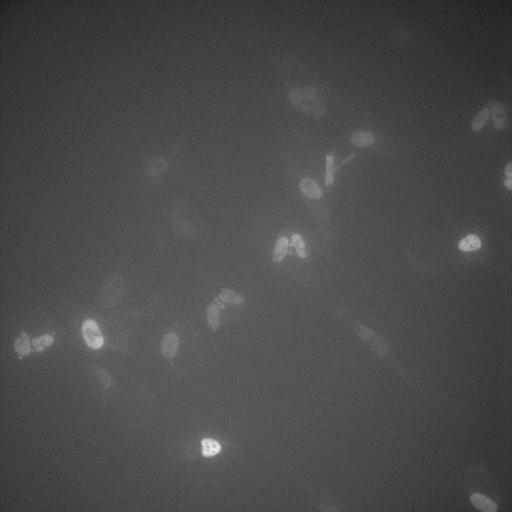

In [5]:
images[1]

# segmentation using by StarDist20

In [6]:
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt
# prints a list of available models
StarDist2D.from_pretrained()
# Define a pretrained model to segment nuclei in fluorescence images (download from pretrained)
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [7]:
@pims.pipeline
def stardist_segm(img):
  img_labels, img_details = model.predict_instances(normalize(img))
  return img_labels

In [8]:
label_image = stardist_segm(images)

2023-02-15 21:21:51.516659: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Text(0.5, 1.0, 'prediction + input overlay')

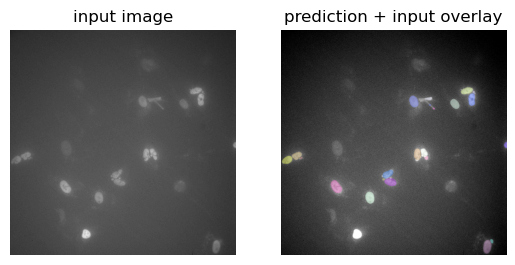

In [9]:
img_num = 16
plt.subplot(1,2,1)
plt.imshow(images[img_num], cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(label_image[img_num], img=images[img_num]))
plt.axis("off")
plt.title("prediction + input overlay")

In [10]:
import skimage
import pandas as pd
features = pd.DataFrame()
for num, img in enumerate(images):
    feature_tem=pd.DataFrame(skimage.measure.regionprops_table(label_image[num], intensity_image=img, properties=['area','centroid','image_intensity','intensity_max','intensity_mean',]))
    feature_tem['frame']=num
    features=pd.concat([features,feature_tem])
features=features.rename(columns={"centroid-0": "y", "centroid-1": "x"},)

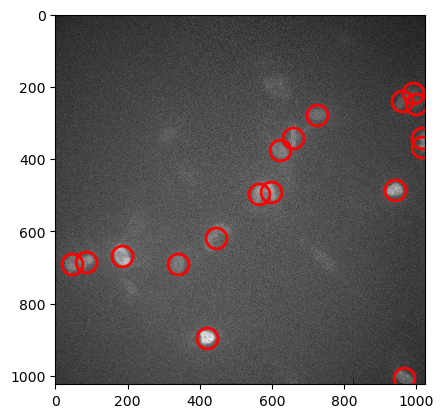

In [11]:
import trackpy as tp

annotated_image=tp.annotate(features[features.frame==(1)], images[1])

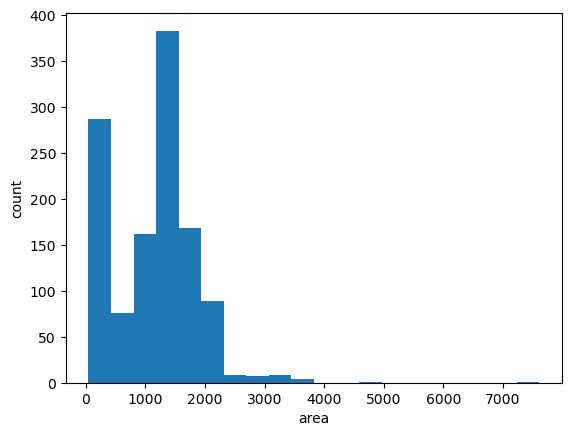

In [12]:
#Plot object areas to investigate the distribution. You can further filter out objects based on size or intensity. Not required in our case.
fig, ax = plt.subplots()
ax.hist(features['area'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='area', ylabel='count');

Frame 57: 23 trajectories present.


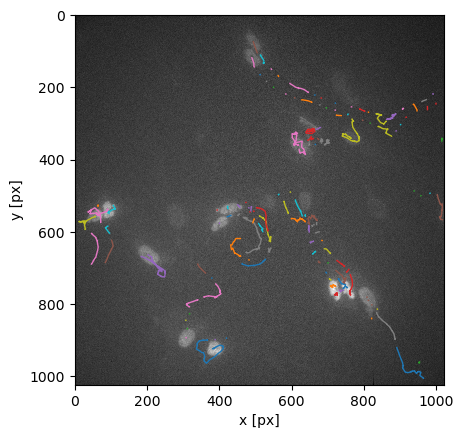

<AxesSubplot: xlabel='x [px]', ylabel='y [px]'>

In [13]:

#Bubble tracking
# we must specify a maximum displacement, the farthest a object can travel between frames (search_range)
# We allow for the possibility that an object might be missed for a few frames and then seen again.
# Memory keeps track of disappeared objects and maintains their ID for up to some number of frames after their last appearance.
# Here we use 5 frames.
#Note that the term particle refers to an object of interest.
search_range = 19
t = tp.link_df(features, search_range, memory=10)
#Plot trajectories
tp.plot_traj(t, superimpose=img) #Remove the superimpose part to just plot the trajectories.

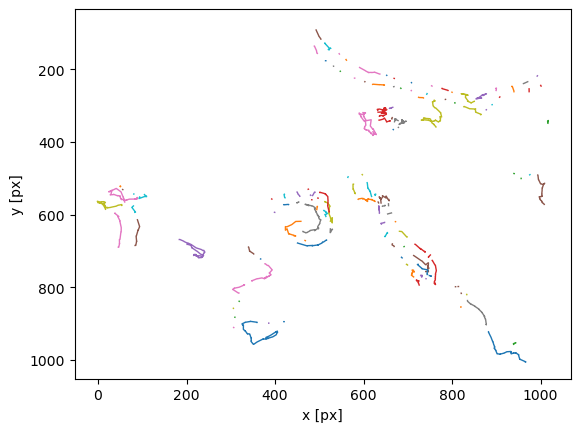

In [14]:
drift = tp.compute_drift(t)
t_corrected = tp.subtract_drift(t.copy(), drift)
ax = tp.plot_traj(t_corrected)
plt.show()


In [15]:
#Velocity field calculation
import numpy as np
data = pd.DataFrame()
for item in set(t.particle):
    sub = t[t.particle==item]
    dvx = np.diff(sub.x)
    dvy = np.diff(sub.y)
    for x, y, dx, dy, frame in zip(sub.x[:-1], sub.y[:-1], dvx, dvy, sub.frame[:-1],):
        data = data.append([{'dx': dx,'dy': dy,'x': x,'y': y,'frame': frame,'particle': item, }])


1542768444.py (9): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
1542768444.py (8): The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
1542768444.py (9): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
1542768444.py (9): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
1542768444.py (9): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
1542768444.py (9): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
154276844

(-0.5, 1023.5, 1023.5, -0.5)

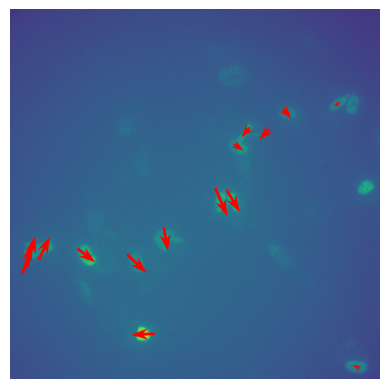

In [16]:
from matplotlib.pyplot import quiver
i = 5
d = data[data.frame==i]
plt.imshow(images[i])
plt.quiver(d.x, d.y, d.dx, -d.dy, pivot='middle', headwidth=4, headlength=6, color='red')
plt.axis('off')
